In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import multivariate_normal
seed = 2022109
np.random.seed(seed)
%matplotlib inline

In [2]:
MNIST_TRAIN_DIR="./Data/MNIST1_train.npz"
MNIST_TEST_1_DIR="./Data/MNIST1_test_1.npz"
PATCHES_DIR="./Data/PATCHES.npy"
ALPHADIGITS_DIR="./Data/binaryalphadigits.npz"

## <span style="color:red">============= Only Gaussian Kernel  =============</span>

In [3]:
class KDE:
    def __init__(self):
        self.name = "KDE"
        self.is_fit = False
    def __str__(self):
        return self.name
    def __repr__(self):
        return str(self)
    def fit(self,X,bandwidth = 0.1):
        n = X.shape[0]
        d = X.shape[1]
        self.Y   = X.copy()
        self.bandwidth = bandwidth
        self.dim = d
        """
        Not Product 
        """
        def pdf(x):
            return (1/(n * (bandwidth ** d) + 1e-10)) * np.array([norm.pdf((x-y)/(bandwidth),0,1) for y in X]).sum(axis = 0)
        def ppf(x):
            return (1/(n * (bandwidth ** d))) * np.array([norm.ppf((x-y)/(bandwidth),0,1) for y in X]).sum(axis = 0)
        self.pdf = pdf
        self.ppf = ppf
        self.is_fit = True
    def sample(self,sample_size):
        if self.is_fit == False:
            raise RuntimeError("You should fit model before call this method")
        sample = []
        for i in range(sample_size):
            idx = np.random.randint(0,len(self.Y))
            sample.append(np.random.normal(self.Y[idx],self.bandwidth,self.dim))
        return np.array(sample)
    def __call__(self,X):
        if self.is_fit == False:
            raise RuntimeError("You should fit model before call this method!")
        return self.pdf(X)

In [4]:
data = np.random.randn(20000,1)
x      = np.linspace(min(data),max(data),100)

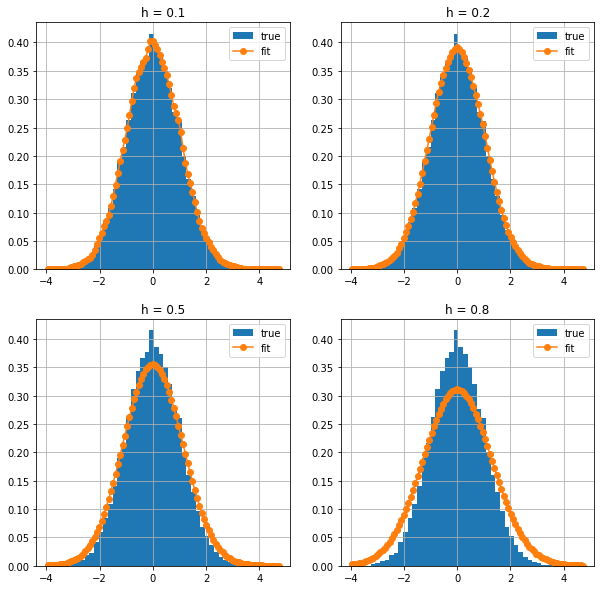

In [5]:
plt.figure(figsize = (10,10))
for i,h in enumerate([0.1,0.2,0.5,0.8]):
    plt.subplot(2,2,i + 1)
    model  = KDE()
    plt.title(f'h = {h}')
    model.fit(data,h)
    sample = model(x)
    plt.hist(data,bins=50,density=True,label='true')
    plt.plot(x,sample,'o-',label = 'fit')
    plt.legend()
    plt.grid()

In [6]:
def show_image(data):
    digits = np.zeros((10 * 28, 10 * 28))
    for i in range(100):
        digits[28 * (i // 10):28 * (i // 10) + 28, 28 * (i % 10):28 * (i % 10) + 28] = np.reshape(data[i],
                                                                                                  newshape=(28, 28))
    plt.imshow(digits)

In [7]:
X =  np.load(MNIST_TRAIN_DIR,allow_pickle=True)["arr_0"]
y =  np.load(MNIST_TRAIN_DIR,allow_pickle=True)["arr_1"]
x_test =  np.load(MNIST_TEST_1_DIR,allow_pickle=True)["arr_0"]
y_test = np.load(MNIST_TEST_1_DIR,allow_pickle=True)["arr_1"]

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=500)
Xtransform = pca.fit_transform(X)
Xtransform.shape

(3000, 500)

In [9]:
model = KDE()
model.fit(Xtransform,bandwidth=0.01)

In [10]:
sample = model.sample(100)
sample.shape

(100, 500)

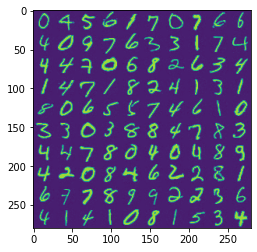

In [11]:
reconstruct = pca.inverse_transform(sample)
reconstruct.shape
show_image(reconstruct)

### fashion_mnist

In [12]:
import tensorflow.keras as keras
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [13]:
sample_image = train_images[:10000].reshape(-1,28 * 28)
sample_image.shape

(10000, 784)

In [14]:
pca_cifar   = PCA(n_components=300)
trans_cifar = pca_cifar.fit_transform(sample_image)
trans_cifar.shape

(10000, 300)

In [15]:
model_cifar = KDE()
model_cifar.fit(trans_cifar,bandwidth=0.2)

In [16]:
sample = model_cifar.sample(100)

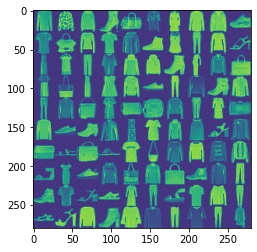

In [17]:
reconstruct = pca_cifar.inverse_transform(sample)
reconstruct.shape
show_image(reconstruct)

### Kernel Regression and Kernel Classification

In [18]:
def gaussian_kernel(x):
    return norm.pdf(x,0,1)
def sigmoid_kernel(x):
    return (1/(np.pi * 2)) * (1/(np.exp(x) + np.exp(-x)))
def cosine_kernel(x):
    return (np.pi/4) * np.cos((np.pi/2) * x)
def logistic_kernel(x):
    return (1/(np.exp(x) + 2 + np.exp(-x)))
def silverman_kernel(x):
    return 0.5 * np.exp(-(np.abs(x)/np.sqrt(2))) * \
        np.sin((np.abs(x)/np.sqrt(2)) + (np.pi/4))
def triweight_kernel(x):
    return (35/32) * (((1 - np.power(x,2))**3))
def cosine_square_kernel(x):
    return cosine_kernel(x) - x**2 + np.abs(x)

In [19]:
kernel_map = {
    'gaussian' : gaussian_kernel,
    'sigmoid'  : sigmoid_kernel,
    'cosine'   : cosine_kernel,
    'logistic' : logistic_kernel,
    'silverman': silverman_kernel,
    'triweight': triweight_kernel,
    #'cosine_squre':cosine_square_kernel
}
x = np.linspace(-10,10,100)

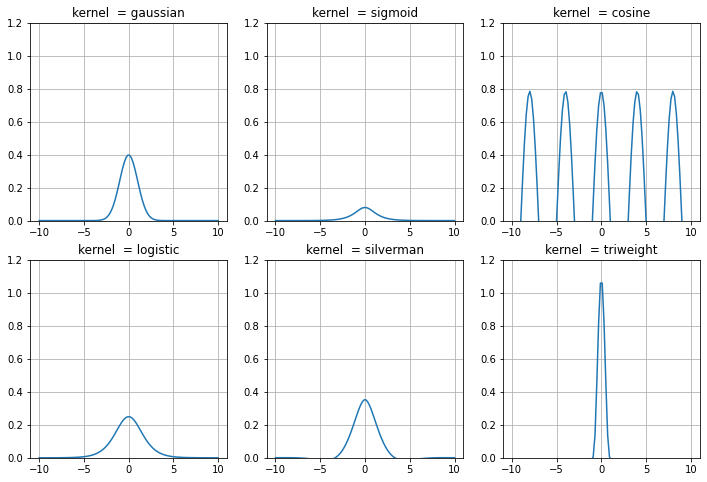

In [20]:
plt.figure(figsize = (12,8))
for i,(k,f) in enumerate(kernel_map.items()):
    plt.subplot(2,3,i + 1)
    plt.title(f"kernel  = {k}")
    plt.plot(x,f(x))
    plt.ylim(0,1.2)
    plt.grid()

In [21]:
from tqdm import tqdm
def expand_label(label,n_class = 2):
    '''
    input : (n,) 
    n_class : unique class encoding
    '''
    n = len(label)
    indice_matrix = np.zeros((n,n_class))
    for i in range(n):
        indice_matrix[i,label[i]] = 1.0
    return indice_matrix



class KernelModel:
    def __init__(self,kernel = "gaussian"):
        self.kernel_function =  {
            'gaussian' : gaussian_kernel,
            'sigmoid'  : sigmoid_kernel,
            'cosine'   : cosine_kernel,
            'logistic' : logistic_kernel,
            'silverman': silverman_kernel,
            'triweight': triweight_kernel,
            'cosine_squre':cosine_square_kernel
            }
        
        
        if kernel not in self.kernel_function.keys():
            raise RuntimeError("Not Implemention Kernel")
        self.kernel   = self.kernel_function[kernel]
        self.describe = f"""
        Kernel Model Method
        kernel function     :{kernel}
        """
        self.is_fit_r = False
        self.is_fit_c = False
    def __str__(self):
        return self.describe
    def __repr__(self):
        return str(self)
    def _check_fit_r(self):
        assert self.is_fit_r == True
    def _check_fit_c(self):
        assert self.is_fit_c == True
        
    def fit_classification(self,x,y,bandwidth = 0.1,copy = True):
        if copy:
            X = x.copy()
            Y = y.copy()
        else:
            X = x
            Y = y
        ######################
        unique_label    = np.unique(Y)
        self.n_label    = len(unique_label)
        self.label_pdfs = {}
        Y               = expand_label(Y,n_class=len(unique_label))
        for label in unique_label:
            pdf = self.fit_regression(X,Y[:,label],bandwidth = bandwidth,return_object = True)
            self.label_pdfs[label] = pdf
        self.is_fit_c = True
    
    ### only one dimension dataset
    def fit_regression(self,o,y,bandwidth = 0.1,copy = True,return_object = False):
        if copy:
            X = o.copy()
            Y = y.copy()
        else:
            X = o
            Y = y
            
        self.mean = np.mean(Y)
        self.std  = np.std(Y)
        def observison_fit(x):
            temp_array =  np.array([self.kernel((x-t)/(bandwidth)).prod(axis = 1) for t in X]).sum(axis = 0)
            temp_array2=  np.array([self.kernel((x-t)/(bandwidth)).prod(axis = 1)* Y[i] for i,t in enumerate(X)]).sum(axis = 0)
            return temp_array2/(temp_array + 1e-10)
            
        self.fit_function = observison_fit
        self.is_fit_r = True
        if return_object:
            return observison_fit
        return self
    
    def predict_classification(self,X,verbose = False):
        self._check_fit_c()
        predict = np.zeros((X.shape[0],self.n_label))
        if verbose:
            bar = tqdm(range(self.n_label))
        else:
            bar = range(self.n_label)
        for i in bar:
            predict[:,i] = self.label_pdfs[i](X)
        return np.argmax(predict,axis = 1)
    def predict_regression(self,X):
        self._check_fit_r()
        return self.fit_function(X)

In [22]:
### Test on boston dataset
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
data = load_boston()
X    = data.data
Y    = data.target

In [23]:
model = KernelModel()
model.fit_regression(X,Y)


        Kernel Model Method
        kernel function     :gaussian
        

In [24]:
predict = model.predict_regression(X)
mean_squared_error(Y,predict)

1.4769080640547388e-07

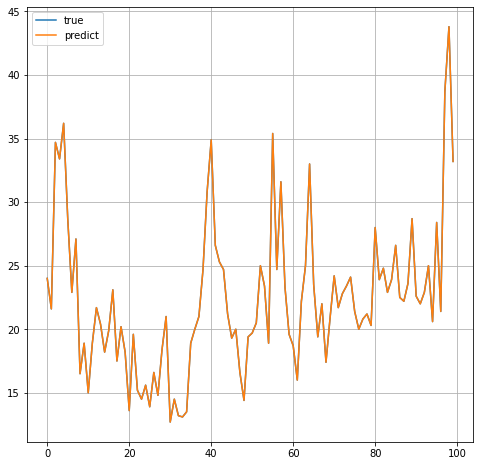

In [25]:
plt.figure(figsize = (8,8))
plt.plot(range(100),Y[:100],label = "true")
plt.plot(range(100),predict[:100],label = 'predict')
plt.grid()
plt.legend()
plt.show()

In [26]:
from sklearn.datasets import make_regression,make_classification
def show_scatter(x,y):
    plt.plot(x,y,"o", alpha=0.5, zorder=-1, label="samples", color="tab:green")
    plt.grid()

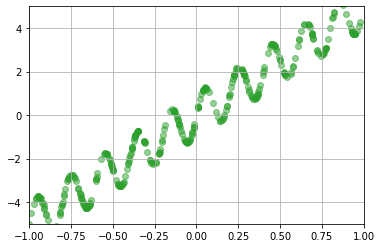

In [27]:
n_samples = 500
rng = np.random.RandomState(0)
X = rng.randn(n_samples, 2)
noise = rng.normal(loc=0.0, scale=0.01, size=n_samples)
y = 5 * X[:, 0] + np.sin(10 * np.pi * X[:, 0]) - noise
show_scatter(X[:,0],y)
plt.xlim(-1,1)
plt.ylim(-5,5)
plt.show()

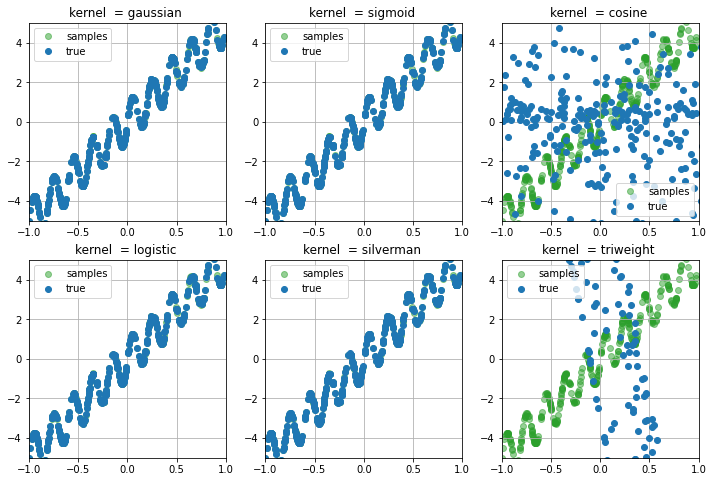

In [28]:
plt.figure(figsize = (12,8))
for i,kernel in enumerate(kernel_map.keys()):
    model = KernelModel(kernel=kernel)
    model.fit_regression(X,y,bandwidth=0.01)
    predict = model.predict_regression(X)
    plt.subplot(2,3,i + 1)
    plt.title(f"kernel  = {kernel} ")
    plt.plot(X[:,0],y,"o", alpha=0.5, zorder=-1, label="samples", color="tab:green")
    plt.plot(X[:,0],predict,"o",label = 'true')
    plt.grid()
    plt.legend()
    plt.xlim(-1,1)
    plt.ylim(-5,5)

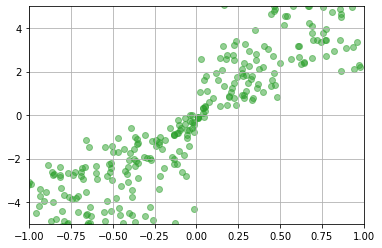

In [29]:
from sklearn.kernel_ridge import KernelRidge
model = KernelRidge(kernel= 'cosine')
model.fit(X,y)
predict = model.predict(X)
show_scatter(X[:,0],predict)
plt.xlim(-1,1)
plt.ylim(-5,5)
plt.show()

### Kernel Classification

In [30]:
### test iris dataset
from sklearn.datasets import load_iris
data  = load_iris()
X     = data.data
Y     = data.target

In [31]:
model = KernelModel()
model.fit_classification(X,Y)

In [32]:
from sklearn.metrics import accuracy_score
accuracy_score(Y,model.predict_classification(X))

1.0

In [33]:
trainX =  np.load(MNIST_TRAIN_DIR,allow_pickle=True)["arr_0"]
trainY =  np.load(MNIST_TRAIN_DIR,allow_pickle=True)["arr_1"]
testX  =  np.load(MNIST_TEST_1_DIR,allow_pickle=True)["arr_0"]
testY  = np.load(MNIST_TEST_1_DIR,allow_pickle=True)["arr_1"]

In [34]:
from sklearn.decomposition import PCA
pca   = PCA(n_components=25).fit(trainX)
trainX_trans = pca.transform(trainX)
testX_trans  = pca.transform(testX)

In [35]:
model = KernelModel()
model.fit_classification(trainX_trans,trainY,bandwidth=0.2)

In [36]:
accuracy_score(testY,model.predict_classification(testX_trans,verbose = True))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]


0.9

### Custom dataset

In [37]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000,shuffle=True, noise=0.1, random_state=seed)

In [38]:
np.unique(y)

array([0, 1], dtype=int64)

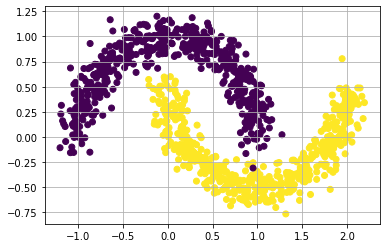

In [39]:
plt.scatter(X[:,0],X[:,1],c = y)
plt.grid()

In [40]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict_classification(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

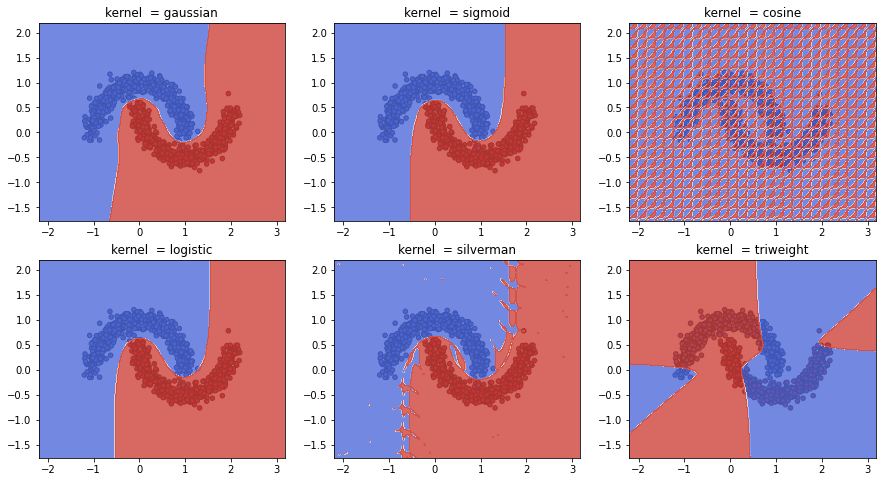

In [41]:
h = 0.1
plt.figure(figsize = (15,8))
for i,kernel in enumerate(kernel_map.keys()):
    model = KernelModel(kernel=kernel)
    model.fit_classification(X,y,bandwidth=h)
    predict = model.predict_classification(X)
    ax = plt.subplot(2,3,i + 1)
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_title(f"kernel  = {kernel}")
    plot_contours(ax, model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)